# Exploratory Data Analysis

In [10]:
import os
import re
# Data manipulation
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Statistical inference
import pingouin as pg
from scipy.stats import kstest, shapiro
from scipy import stats

# Set pandas dataframe display options
pd.options.display.max_columns = None
pd.options.display.max_rows = 500

## Load Dataset

In [11]:
df = pd.read_csv('../data/raw/loan_data.csv', sep=',')

In [12]:
# Adjust columns names
df.columns = [col.replace('.', '_') for col in df.columns.values]
# Rename target column
df = df.rename(columns={'not_fully_paid': 'default'})

In [13]:
# Checking shape of the data
df.shape

(9578, 14)

This dataframe consists of 9578 observatios and 14 variables( 13 predictors and 1 target variable)

In [14]:
# Check columns general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int_rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log_annual_inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days_with_cr_line  9578 non-null   float64
 8   revol_bal          9578 non-null   int64  
 9   revol_util         9578 non-null   float64
 10  inq_last_6mths     9578 non-null   int64  
 11  delinq_2yrs        9578 non-null   int64  
 12  pub_rec            9578 non-null   int64  
 13  default            9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Missing values

In [15]:
# Check for missing values
df.isna().sum()

credit_policy        0
purpose              0
int_rate             0
installment          0
log_annual_inc       0
dti                  0
fico                 0
days_with_cr_line    0
revol_bal            0
revol_util           0
inq_last_6mths       0
delinq_2yrs          0
pub_rec              0
default              0
dtype: int64

The is not missing values in the dataset

## Duplicated records

In [16]:
df.duplicated().sum()

0

There is not duplicated records in the dataset

## Target Variable Distribution

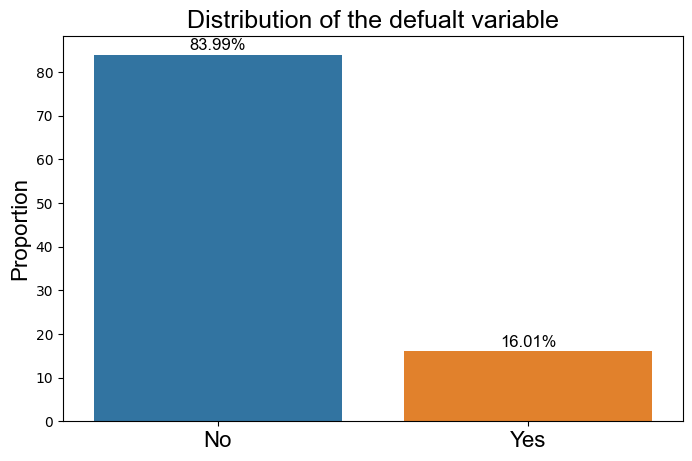

In [17]:
target = df.default.value_counts(normalize=True).to_frame().reset_index()
target['proportion'] = round(target.proportion * 100, 2)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(data=target, x='default', y='proportion', hue='default', legend=False)
ax.set_xlabel(None)
ax.set_title("Distribution of the defualt variable",
             fontdict={'fontname': 'Arial', 'fontsize': 18})
ax.set_xticks(range(2))
ax.set_xticklabels(['No', 'Yes'], fontdict={'fontname': 'Arial', 'fontsize': 16})
ax.set_ylabel("Proportion", fontdict={'fontname': 'Arial', 'fontsize': 16})

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.2f}%',
        ha='center',
        fontname='Arial',
        fontsize=12
    )

plt.show()

We can see that the target variable is unbalanced, 84% of the clients did not default and 16% are default.

## Univariate Analysis

In this seccion numerical and categorical variables are analized independently in order to have an idea of their distributions

In [18]:
def univariated_num_plot(df, var_name, box_xlabel, figheight=5, figwidth=8,
                     fuente='Arial', fig_fontsize=18, title_fontsize=16, 
                     ylabel_fontsize=14):
    "Create univariated plots for numerical variables"
    
    # mean (mu) and standar deviation (sigma) from int_rate data
    mu, sigma = stats.norm.fit(df[var_name])

    # Theorical values for the normal distribution
    x_hat = np.linspace(min(df[var_name]), max(df[var_name]), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)
    
    fig, axes = plt.subplots(1, 2, figsize=(figwidth, figheight))
    fig.suptitle(f"Distribution of the variable - {var_name.capitalize()}", fontsize=fig_fontsize)
    # Boxplot
    sns.boxplot(data=df, y=var_name, ax=axes[0])
    # Density
    axes[1].plot(x_hat, y_hat, linewidth=2, color='r', label='Normal')
    axes[1].hist(x=df[var_name], density=True, bins=30, color="#3182bd", alpha=0.5)
    sns.rugplot(data=df, x=var_name, color='#343a40', alpha=0.5, ax=axes[1])
    # Text format
    axes[0].set_title('Box Plot', fontdict={'fontname': fuente,
                                            'size': title_fontsize})
    axes[0].set_ylabel(box_xlabel, fontdict={'fontname': fuente, 
                                             'size': ylabel_fontsize})
    axes[0].set_xlabel(None)
    axes[1].set_title('Density Plot', fontdict={'fontname': fuente,
                                                'size': title_fontsize})
    axes[1].set_ylabel("Frequency", fontdict={'fontname': fuente, 'size': ylabel_fontsize})
    axes[1].set_xlabel(box_xlabel)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [19]:
# Split the original dataframen into 2 dataframes, one for numerical variables and another for categorical variables
num_df = df.select_dtypes(exclude=['object', 'category'])
num_df = num_df.drop('default', axis=1) # drop target variable

cat_df = df.select_dtypes(include=['object', 'category'])

### Numeric Variables

In [20]:
(num_df
 .describe()
 .T
 .style
 .format({
     'count': '{0:.0f}',
     'mean': '{0:.4f}',
     'std': '{0:.4f}',
     '25%': '{0:.4f}',
     '50%': '{0:.4f}',
     '75%': '{0:.4f}',
     'max': '{0:.4f}'
     }) 
)

,count,mean,std,min,25%,50%,75%,max
credit_policy,9578,0.8050,0.3962,0.000000,1.0000,1.0000,1.0000,1.0000
int_rate,9578,0.1226,0.0268,0.060000,0.1039,0.1221,0.1407,0.2164
installment,9578,319.0894,207.0713,15.670000,163.7700,268.9500,432.7625,940.1400
log_annual_inc,9578,10.9321,0.6148,7.547502,10.5584,10.9289,11.2913,14.5284
dti,9578,12.6067,6.8840,0.000000,7.2125,12.6650,17.9500,29.9600
fico,9578,710.8463,37.9705,612.000000,682.0000,707.0000,737.0000,827.0000
days_with_cr_line,9578,4560.7672,2496.9304,178.958333,2820.0000,4139.9583,5730.0000,17639.9583
revol_bal,9578,16913.9639,33756.1896,0.000000,3187.0000,8596.0000,18249.5000,1207359.0000
revol_util,9578,46.7992,29.0144,0.000000,22.6000,46.3000,70.9000,119.0000
inq_last_6mths,9578,1.5775,2.2002,0.000000,0.0000,1.0000,2.0000,33.0000


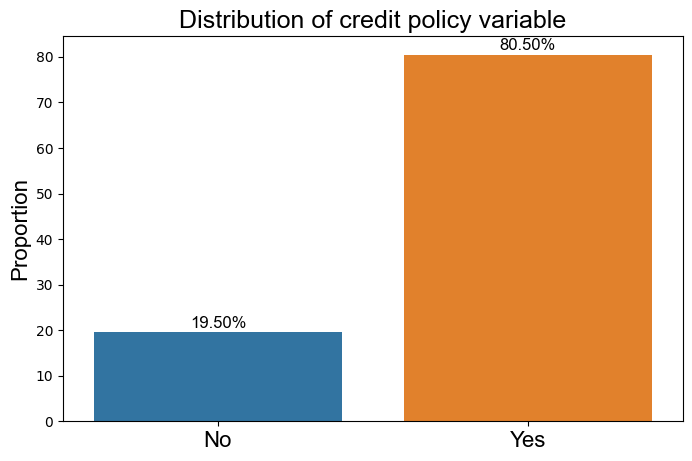

In [21]:
# univariated_plot(num_df, var_name='credit_policy', box_xlabel='Credit Policy')
policy = df.credit_policy.value_counts(normalize=True).to_frame().reset_index()
policy['proportion'] = round(policy.proportion * 100, 2)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(data=policy, x='credit_policy', y='proportion', hue='credit_policy', legend=False)
ax.set_xlabel(None)
ax.set_title("Distribution of credit policy variable",
             fontdict={'fontname': 'Arial', 'fontsize': 18})
ax.set_xticks(range(2))
ax.set_xticklabels(['No', 'Yes'], fontdict={'fontname': 'Arial', 'fontsize': 16})
ax.set_ylabel("Proportion", fontdict={'fontname': 'Arial', 'fontsize': 16})

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.2f}%',
        ha='center',
        fontname='Arial',
        fontsize=12
    )

plt.show()

Most of the customers meet the Lending Club credit policy

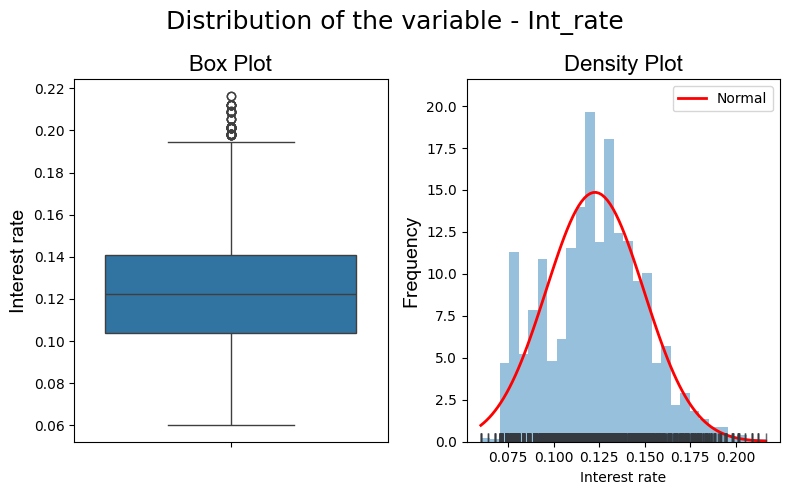

In [22]:
univariated_num_plot(num_df, var_name='int_rate', box_xlabel='Interest rate')

50% of the customers has an interes rate lower than 12.21%. The interest rate appearst to follow a normal distribution, so I will perfmon the ks test for testing normality in the interes rate distribution.

The null and alternative hypothesis are:

***Ho:*** The int_rate variable follows a normal distribution <br>
***Ha:*** The int_rate variable doesn't follow a normal distribution

The test is perfomed with a significance level of 5%

In [23]:
alpha = 0.05

# Normality test
stat, p_value = kstest(num_df.int_rate, stats.norm.cdf)

if p_value > alpha:
    print("Fail to reject Ho. The int_rate variable does follow a normal distribution")
else:
    print("Reject Ho. The int_rate variable does not follow a normal distribution")

Reject Ho. The int_rate variable does not follow a normal distribution


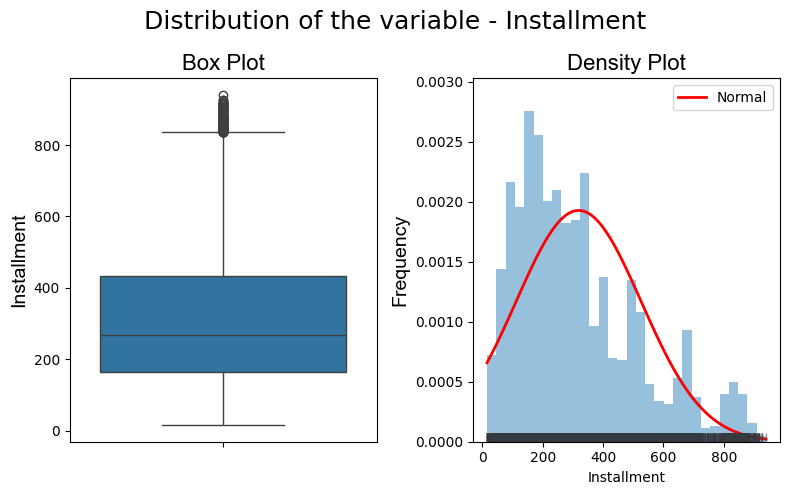

In [24]:
univariated_num_plot(num_df, var_name='installment', box_xlabel='Installment')

Most of the customers have a monthly installment under 400. The variable doesn't follow a normal distribution, its distribution is right skedwd

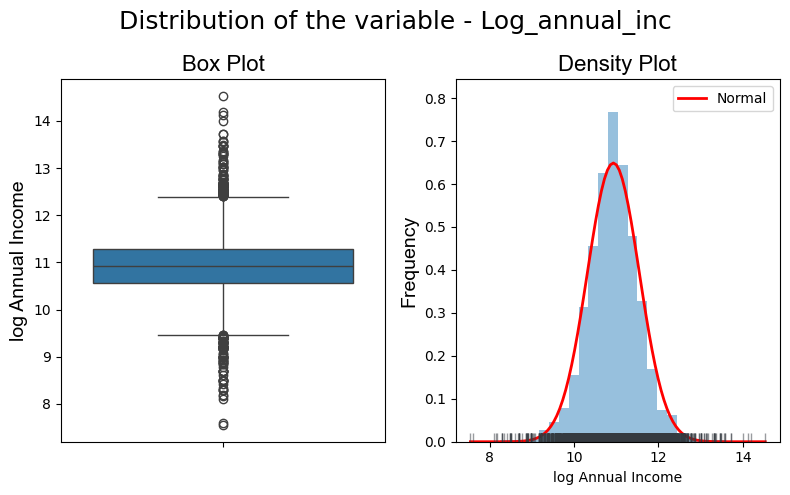

In [25]:
univariated_num_plot(num_df, var_name='log_annual_inc', box_xlabel='log Annual Income')

The annual income was transformed in the dataset using the natural log. According to the plot, the variable follows a normal distribution and there are some posible outlier in both tails

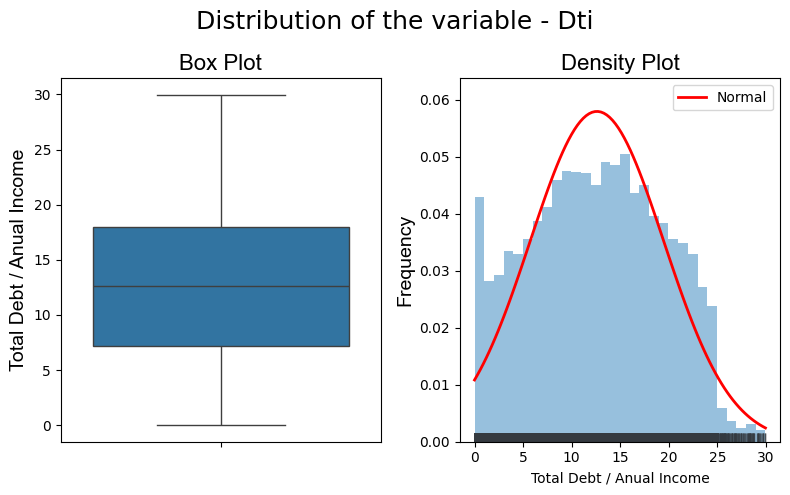

In [26]:
univariated_num_plot(num_df, var_name='dti', box_xlabel='Total Debt / Anual Income')

The dti variable tells us at hos indebted the clients are. The higher the value the riskier a customer is. In the case of the LendingClub's customers, the greatest debt to income ratio is about 30% and most of customers have a dti around 15%.

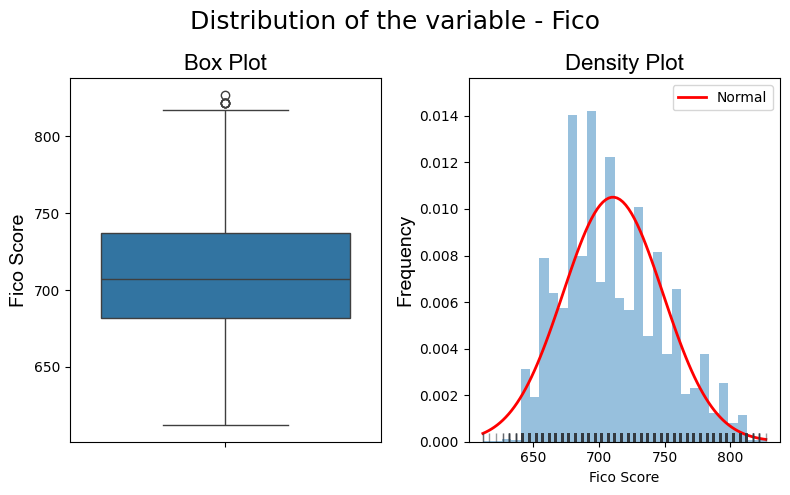

In [27]:
univariated_num_plot(num_df, var_name='fico', box_xlabel='Fico Score')

FICO score is a credit score which uses socio-demographic, financial and behavioral information, among others. This score typically has a value from 300 to 850. The higher the value the better. According to the grahps we can see tha 50% of the customers has a FICO score between 682 (Q1) and 737 (Q3). <br>

The distribution seems to be simetric, with a range between 612 and 827

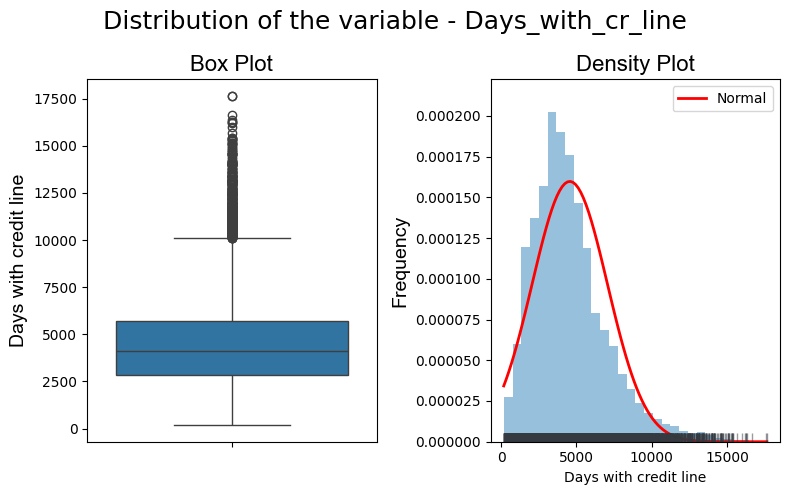

In [28]:
univariated_num_plot(num_df, var_name='days_with_cr_line', box_xlabel='Days with credit line')

The days_with_cr_line variable has a right skewed distribution, so there are posible outlier to the upper tail. Most of customer have had credit line for 4139 days (10 year aprox) or les 

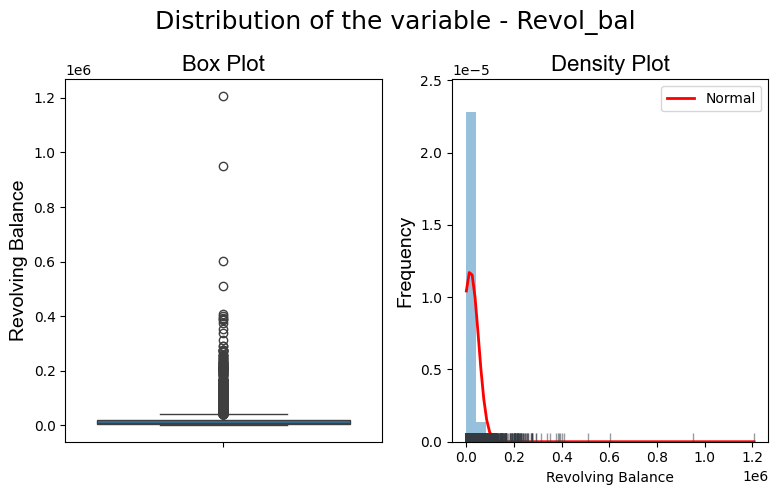

In [29]:
univariated_num_plot(num_df, var_name='revol_bal', box_xlabel='Revolving Balance')

The revol_val variable tells us the amount unpaid for the customer at the end of the credit card billing cycle. We can see the distribution is heavy-tailed to the right.

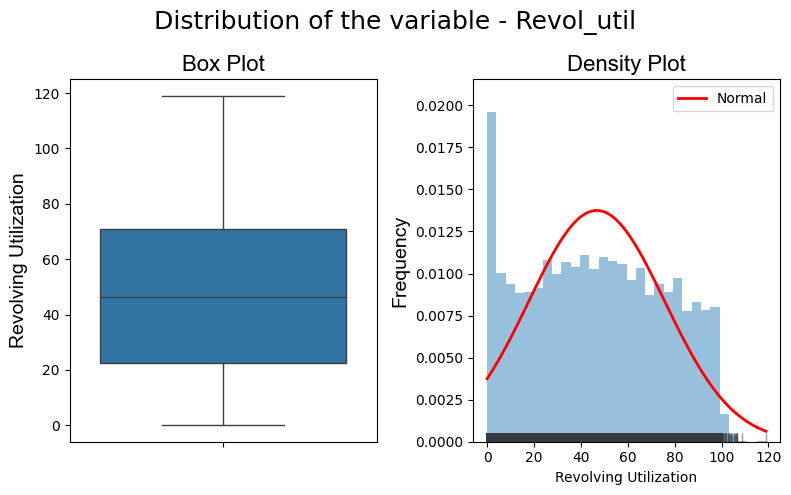

In [30]:
univariated_num_plot(num_df, var_name='revol_util', box_xlabel='Revolving Utilization')

The revolving utilization rate varible seems to follow a uniform distribution. Apparently there are not outliers. However the distribution shows there are customers who have used more than the total credit available.

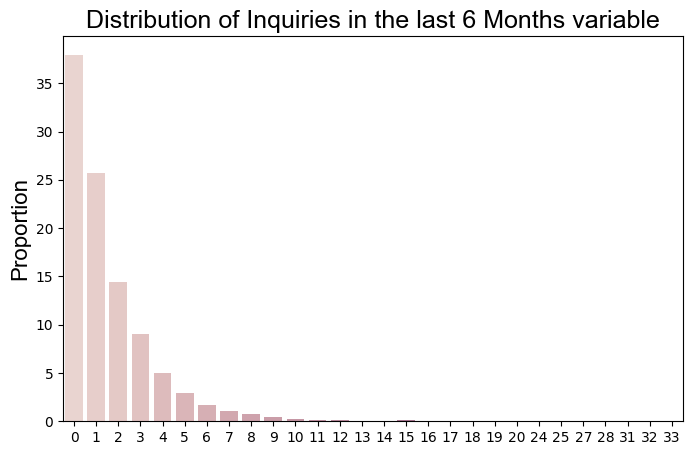

In [31]:
# univariated_plot(num_df, var_name='inq_last_6mths', box_xlabel='Inquiries in last 6 months')
inquiries_6m = df.inq_last_6mths.value_counts(normalize=True).to_frame().reset_index()
inquiries_6m['proportion'] = round(inquiries_6m.proportion * 100, 2)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(data=inquiries_6m, x='inq_last_6mths', y='proportion', hue='inq_last_6mths', legend=False)
ax.set_xlabel(None)
ax.set_title("Distribution of Inquiries in the last 6 Months variable",
             fontdict={'fontname': 'Arial', 'fontsize': 18})
# ax.set_xticklabels(['No', 'Yes'], fontdict={'fontname': 'Arial', 'fontsize': 16})
ax.set_ylabel("Proportion", fontdict={'fontname': 'Arial', 'fontsize': 16})

# for p in ax.patches:
#     height = p.get_height()
#     ax.text(
#         p.get_x() + p.get_width() / 2,
#         height + 1,
#         f'{height:.2f}%',
#         ha='center',
#         fontname='Arial',
#         fontsize=12
#     )

plt.show()

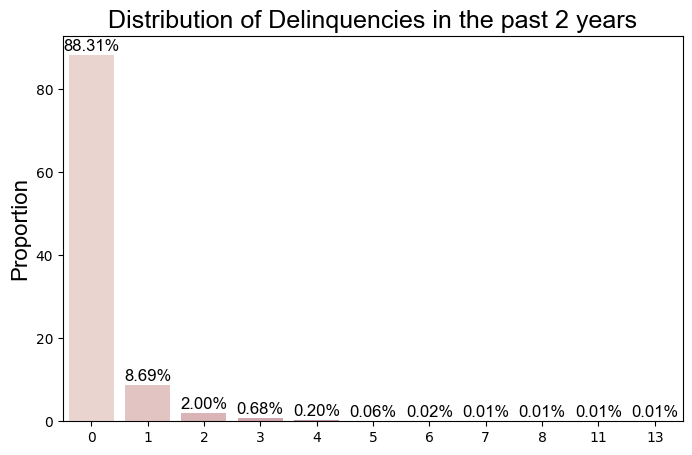

In [32]:
# univariated_plot(num_df, var_name='delinq_2yrs', box_xlabel='# times 30+ past due in the past 2 years')
delinq_2y = df.delinq_2yrs.value_counts(normalize=True).to_frame().reset_index()
delinq_2y['proportion'] = round(delinq_2y.proportion * 100, 2)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(data=delinq_2y, x='delinq_2yrs', y='proportion', hue='delinq_2yrs', legend=False)
ax.set_xlabel(None)
ax.set_title("Distribution of Delinquencies in the past 2 years",
             fontdict={'fontname': 'Arial', 'fontsize': 18})
# ax.set_xticklabels(['No', 'Yes'], fontdict={'fontname': 'Arial', 'fontsize': 16})
ax.set_ylabel("Proportion", fontdict={'fontname': 'Arial', 'fontsize': 16})

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.2f}%',
        ha='center',
        fontname='Arial',
        fontsize=12
    )

plt.show()

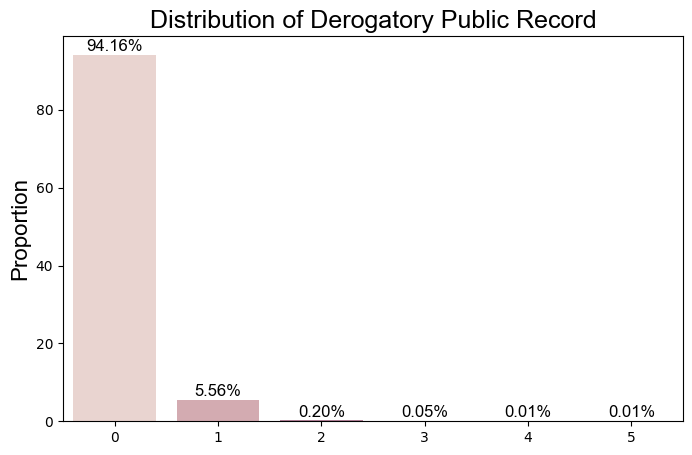

In [33]:
# univariated_plot(num_df, var_name='pub_rec', box_xlabel='Derogatory Public Record')
pub_rec = df.pub_rec.value_counts(normalize=True).to_frame().reset_index()
pub_rec['proportion'] = round(pub_rec.proportion * 100, 2)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=pub_rec, x='pub_rec', y='proportion', hue='pub_rec', legend=False, ax=ax)
ax.set_xlabel(None)
ax.set_title("Distribution of Derogatory Public Record",
             fontdict={'fontname': 'Arial', 'fontsize': 18})
# ax.set_xticklabels(['No', 'Yes'], fontdict={'fontname': 'Arial', 'fontsize': 16})
ax.set_ylabel("Proportion", fontdict={'fontname': 'Arial', 'fontsize': 16})

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        
        height + 1,
        f'{height:.2f}%',
        ha='center',
        fontname='Arial',
        fontsize=12
    )

plt.show()

### Categorical Variables

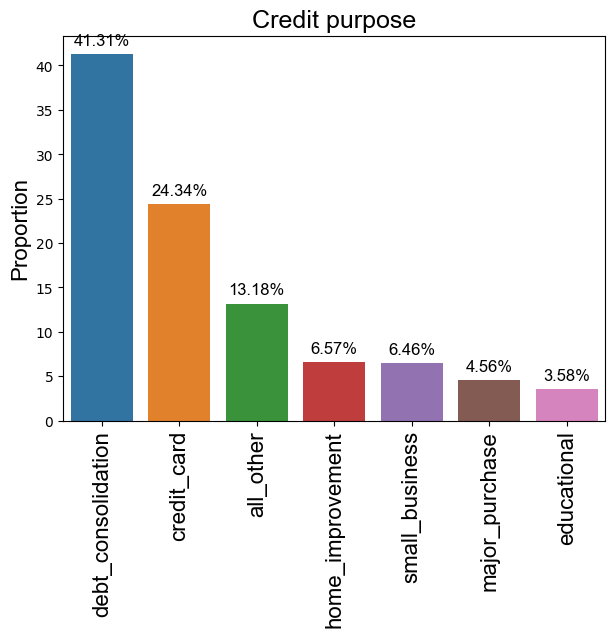

In [34]:
cred_purpose = df.purpose.value_counts(normalize=True).to_frame().reset_index()
cred_purpose['proportion'] = round(cred_purpose.proportion * 100, 2)

fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.barplot(data=cred_purpose, x='purpose', y='proportion', hue='purpose', legend=False)
ax.set_xlabel(None)
ax.set_title("Credit purpose",
             fontdict={'fontname': 'Arial', 'fontsize': 18})
ax.set_xticks(range(len(cat_df.purpose.unique())))
ax.set_xticklabels(cat_df.purpose.unique(),
                   fontdict={'fontname': 'Arial', 'fontsize': 16},
                   rotation=90)
ax.set_ylabel("Proportion", fontdict={'fontname': 'Arial', 'fontsize': 16})

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        
        height + 1,
        f'{height:.2f}%',
        ha='center',
        fontname='Arial',
        fontsize=12
    )

plt.show()

From the plot we can tell that the paretto for the purpose of the credit is for debt consolidation, credit card and some other purposes.

## Bivariate Analysis

From the univariate analysis we saw that the base defualt rate is 16%. <br>

In this section a bivariate analysis will be perfomed in order to identify which of the predictor variables can help us detecting default.

For plotting the bivariate plots, the function "bivariated_num_default_plot" is created

In [35]:
def bivariated_num_default_plot(df, 
                            var_name, 
                            box_xlabel,
                            figheight=5, 
                            figwidth=10, 
                            fontname='Arial', 
                            fig_fontsize=18, 
                            title_fontsize=16, 
                            ylabel_fontsize=14,
                            xtick_fontsize=12, 
                            ytick_fontsize=14):
    """Function to create a bivariate plot for numerical variables against
    the target variable (Default)
    """
    fig, axes = plt.subplots(1, 2, figsize=(figwidth, figheight))
    fig.suptitle(f"Distribution of the variable - {var_name.capitalize()}", fontsize=fig_fontsize)
    sns.boxplot(data=df, y=var_name, x='default', hue='default', ax=axes[0])
    sns.kdeplot(data=df, x=var_name, hue='default', fill=True, ax=axes[1])
    axes[0].set_title('Box Plot', fontdict={'fontname': fontname, 'size': title_fontsize})
    axes[0].set_ylabel(box_xlabel, fontdict={'fontname': fontname,'size': ylabel_fontsize})
    axes[0].set_xlabel(None)
    axes[0].set_xticks(range(2))
    axes[0].set_xticklabels(['No Default', 'Default'],
                            fontdict={'fontname': fontname,
                                      'fontsize': xtick_fontsize})
    axes[0].get_legend().set_visible(False)
    axes[1].set_title('Density Plot', fontdict={'fontname': fontname,
                                                            'size': title_fontsize})
    axes[1].set_ylabel("Density", fontdict={'fontname': fontname,
                                             'size': ylabel_fontsize})
    axes[1].set_xlabel(None)
    axes[1].legend(['Default', 'No Default'], bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

### Credit Policy vs Default

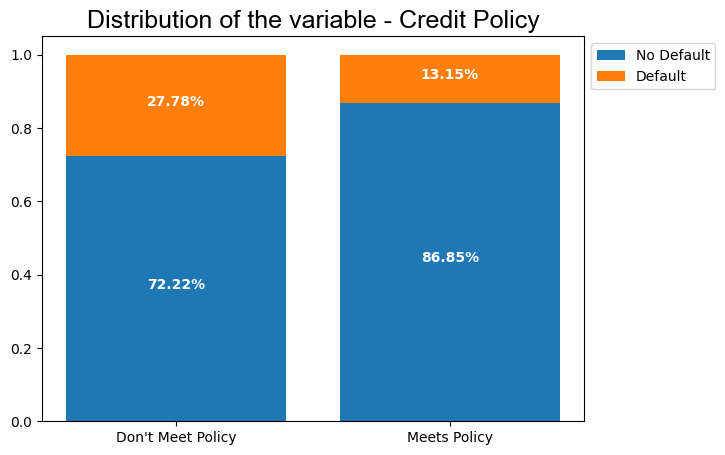

In [36]:
credit_policy = df.groupby('credit_policy')['default'].value_counts(normalize=True).unstack()
credit_policy.columns = ['no_default', 'default']
credit_policy = credit_policy.reset_index()

groups = ["Don't Meet Policy", 'Meets Policy']
no_default = credit_policy.no_default.tolist()
default = credit_policy.default.tolist()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(groups, no_default, label = "No Default")
ax.bar(groups, default, bottom=no_default, label="Default")
ax.set_title("Distribution of the variable - Credit Policy",
             fontdict={'fontname': 'Arial', 'fontsize':18})
ax.legend(bbox_to_anchor=(1, 1))
# Labels
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        f'{round(bar.get_height() * 100, 2)}%',
        ha='center',
        color='w',
        weight='bold'
    )

plt.show()

From this plot we can see that customer who meets the Lendin Club credit policy tends to default lesser than the ones who doesn't meet the policy

### Interest Rate vs Default

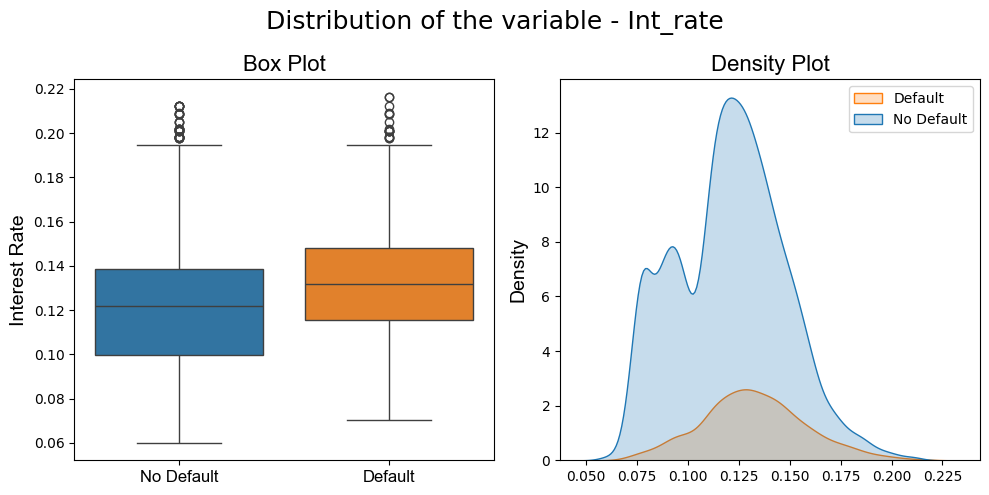

In [37]:
bivariated_num_default_plot(df, var_name='int_rate', box_xlabel='Interest Rate')

Customers with higher interest rate tends to default the more

### Installment vs Default

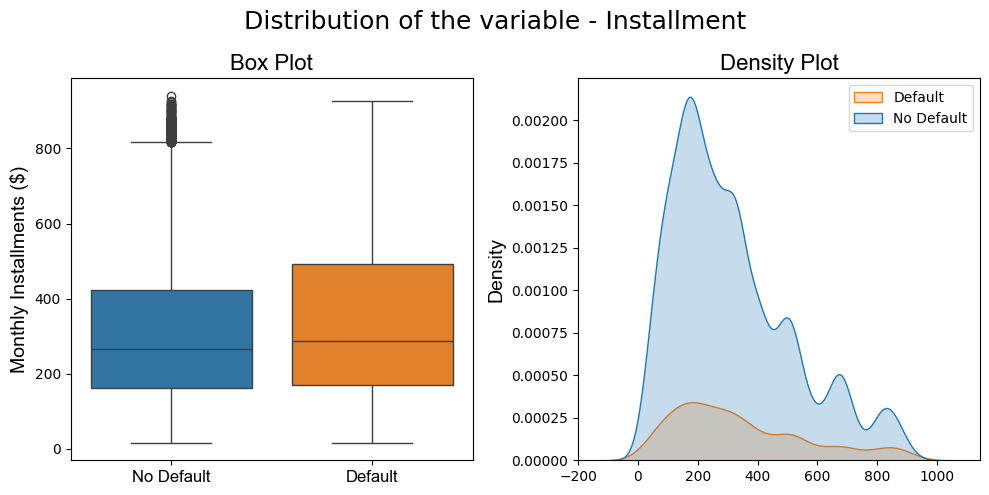

In [38]:
bivariated_num_default_plot(df, var_name='installment', box_xlabel='Monthly Installments ($)')

At glance it seems that there is not difference in the installments for default and non default customers. So we perform a hypotesis testig to evaluate if the means difference are statiscally significant.

In [39]:
# Hypotesis testing for installment
pg.ttest(x=df.query("default == 1").installment,
         y=df.query("default == 0").installment,
         correction=True,
         alternative='greater'
         )

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.585001,2041.864143,greater,0.000002,"[18.09, inf]",0.136401,2210.645,0.999422


According the the test, there is a significant difference between the two means. So we can think, that defualt customers have a higher average installment

### Log Annual Income vs Default

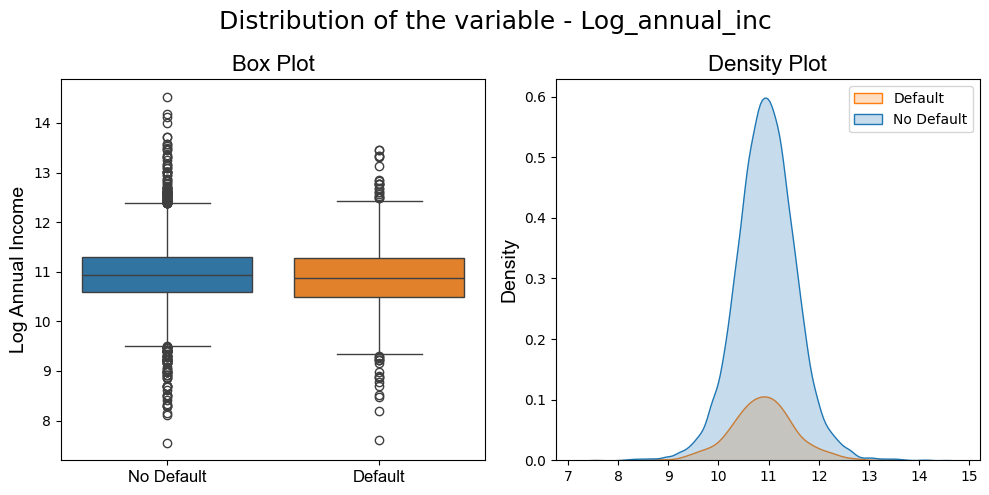

In [40]:
bivariated_num_default_plot(df, var_name='log_annual_inc', box_xlabel='Log Annual Income')

In terms of the income, it seems there is no differences in the distributions

### Debt to Income vs Default

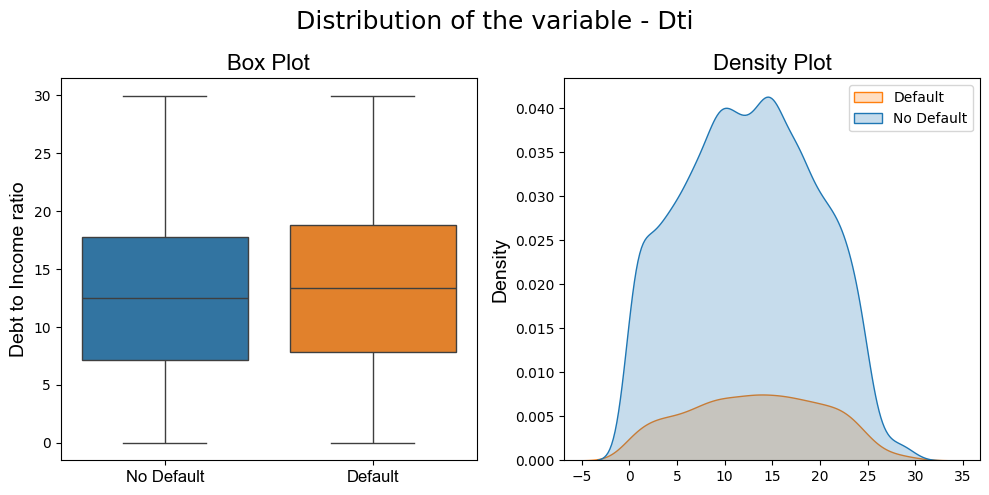

In [41]:
bivariated_num_default_plot(df, var_name='dti', box_xlabel='Debt to Income ratio')

From the plot we can tell that customer who defualt tends to have a greater debt to income ratio. It means, that customer who defualts has higher amount of debt compare to their incomes

### FICO Score vs Default

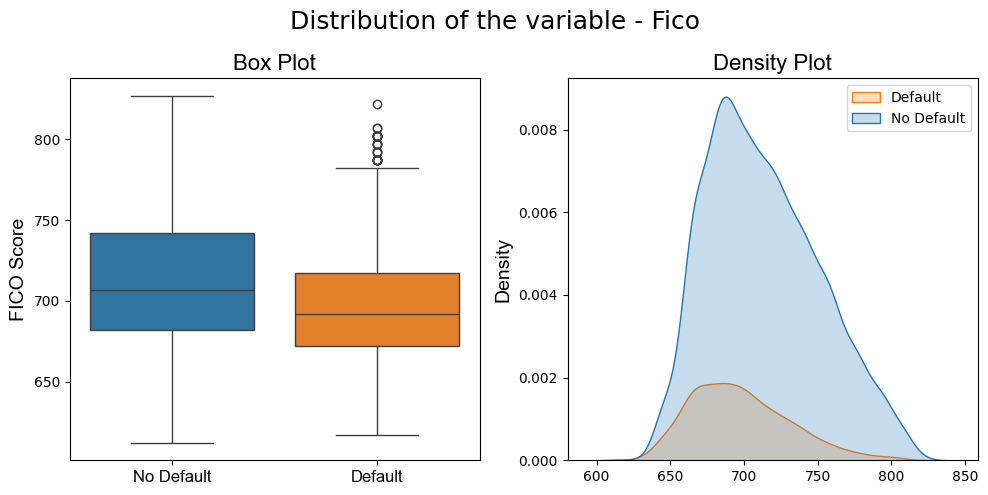

In [42]:
bivariated_num_default_plot(df, var_name='fico', box_xlabel='FICO Score')

Customers with lower FICO scores defaults the more

### Days with Credit Line vs Default

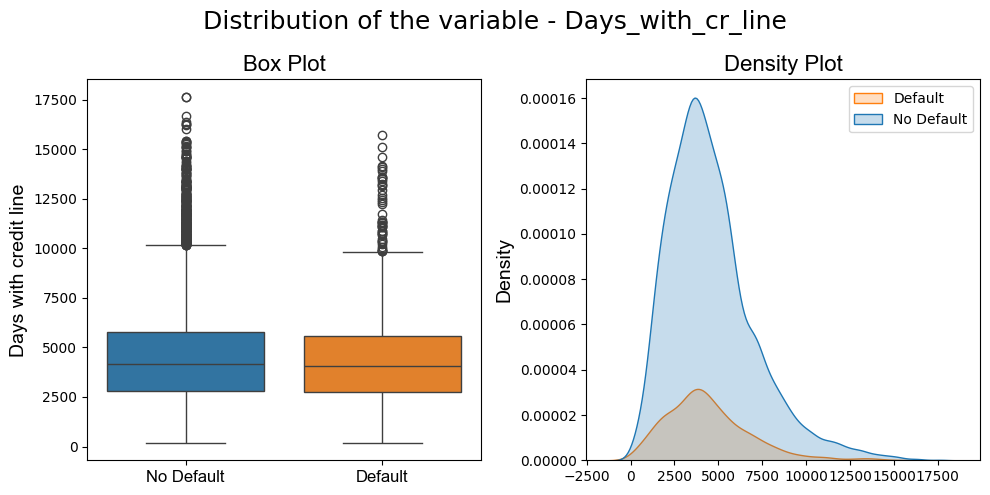

In [43]:
bivariated_num_default_plot(df, var_name='days_with_cr_line', box_xlabel='Days with credit line')

There is not differences in the distributions for the variable Days with credit line

### Revolving Balance vs Default

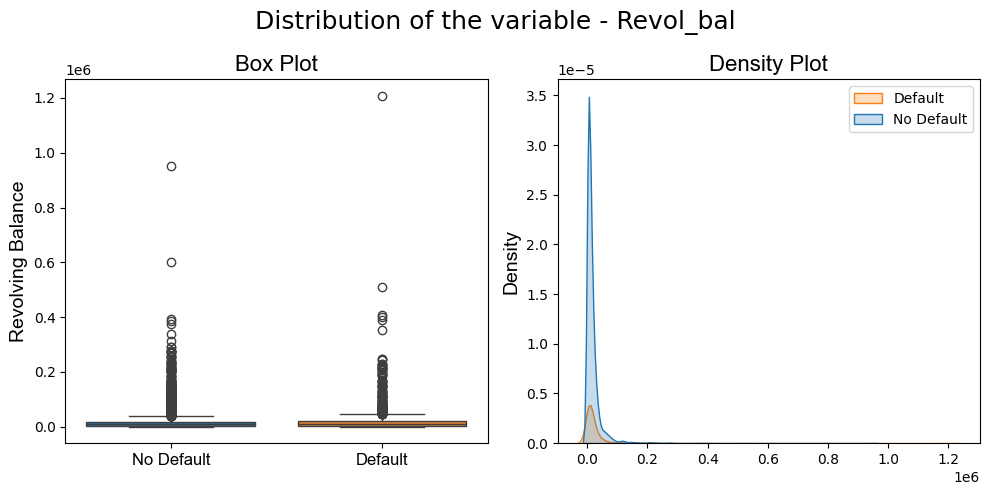

In [44]:
bivariated_num_default_plot(df, var_name='revol_bal', box_xlabel='Revolving Balance')

The revolving balance dont seem to have a significant difference

### Revolving Line Utilization vs Default

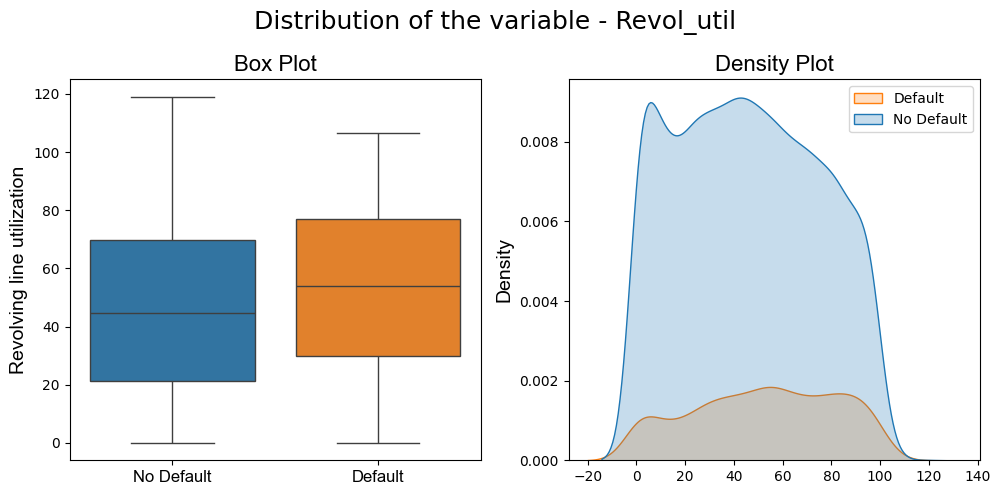

In [45]:
bivariated_num_default_plot(df, var_name='revol_util', box_xlabel='Revolving line utilization')

Customers with higher levels of line utilization default the more

### Inquiries Last 6mths vs Default

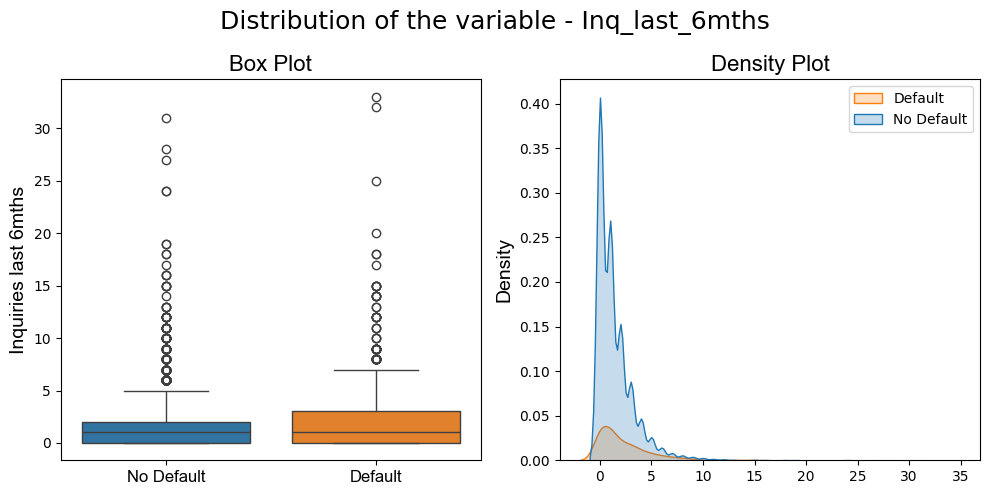

In [46]:
bivariated_num_default_plot(df, var_name='inq_last_6mths', box_xlabel='Inquiries last 6mths')

Customers who defaulted have more inquiries in the last 6 months

### Delinquencies in the past 2 years vs Default

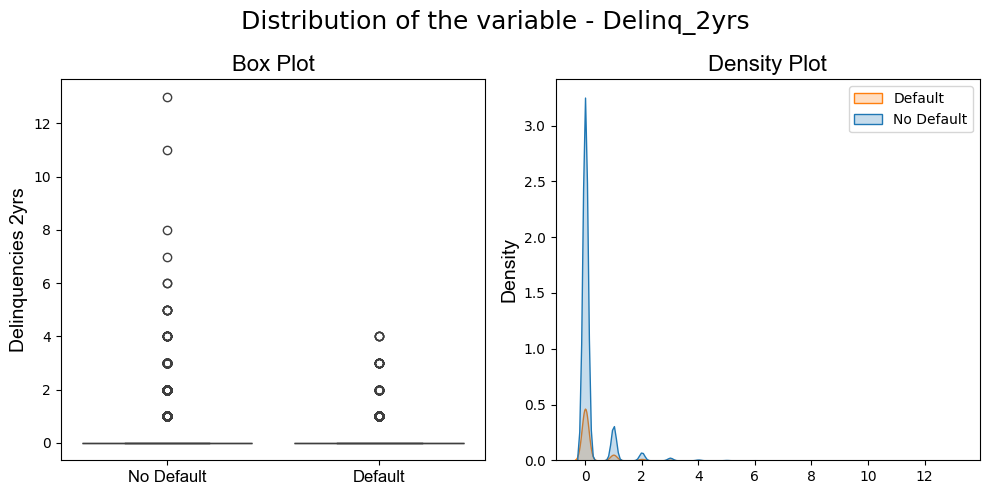

In [47]:
bivariated_num_default_plot(df, var_name='delinq_2yrs', box_xlabel='Delinquencies 2yrs')

It does not seem to be a difference in the distributios of the variable delinquencies in the past 2 years since most of the customers have 0 delinquencies

### Derogatory Public Records vs Default

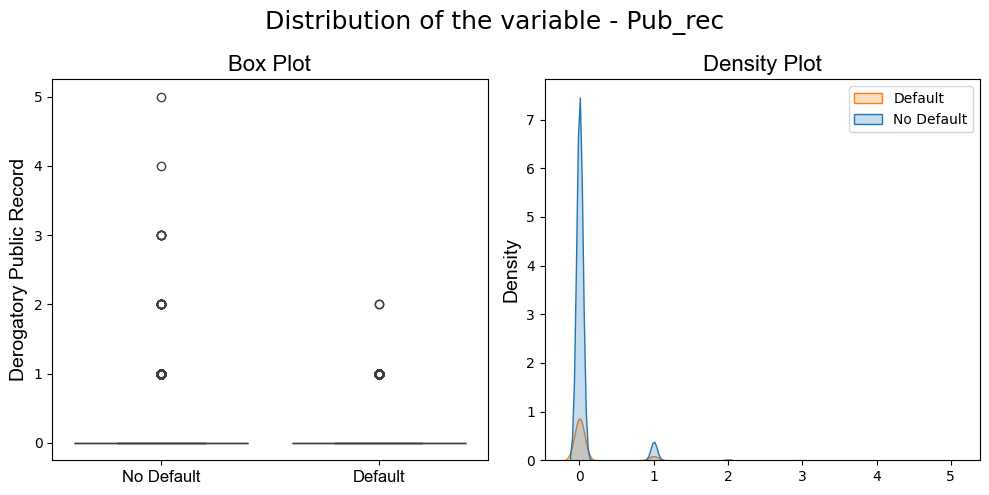

In [48]:
bivariated_num_default_plot(df, var_name='pub_rec', box_xlabel='Derogatory Public Record')

It does not seem to be a difference in the distributios of the variable derogatory public records, since most of the customers have a value of 0

### Loan Purpose vs Default

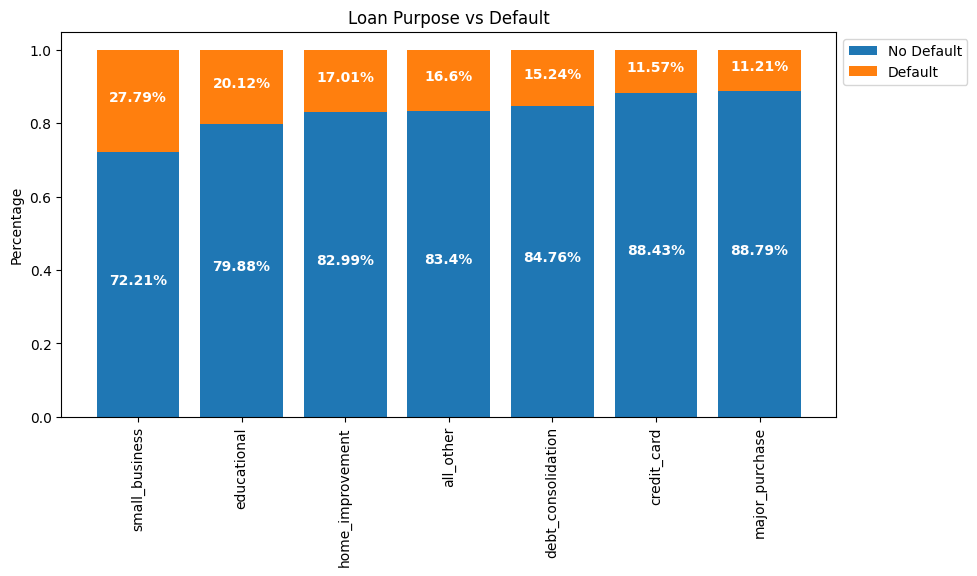

In [49]:
purpose = df.groupby(by='purpose')['default'].value_counts(normalize=True)
purpose = purpose.unstack()
purpose = purpose.reset_index()
purpose = purpose.rename(columns={0: 'no_default', 1: 'default'})
purpose = purpose.sort_values(by='default', ascending=False)

groups = purpose.purpose.tolist()
no_default = purpose.no_default.tolist()
default = purpose.default.tolist()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(groups, no_default, label='No Default')
ax.bar(groups, default, bottom=no_default, label='Default')
ax.set(
    title="Loan Purpose vs Default",
    ylabel='Percentage'
)
ax.set_xticks(range(len(groups)))
ax.set_xticklabels(rotation=90, labels=groups)
# Labels
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        f'{round(bar.get_height() * 100, 2)}%',
        ha = 'center',
        color = 'w',
        weight = 'bold',
        size = 10
    )
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

small business, educational and home improvement are the purposes with the higest levels of default

## Correlation Analysis

From the exploratory data anaylisis we can see that some predictors which could help us to identify default customers are:
- credit_policy 
- int_rate 
- installment 
- dti 
- fico 
- revol_util 
- inq_last_6mths 
- purpose

Next, we evaluate if some of this variable are correlated each other

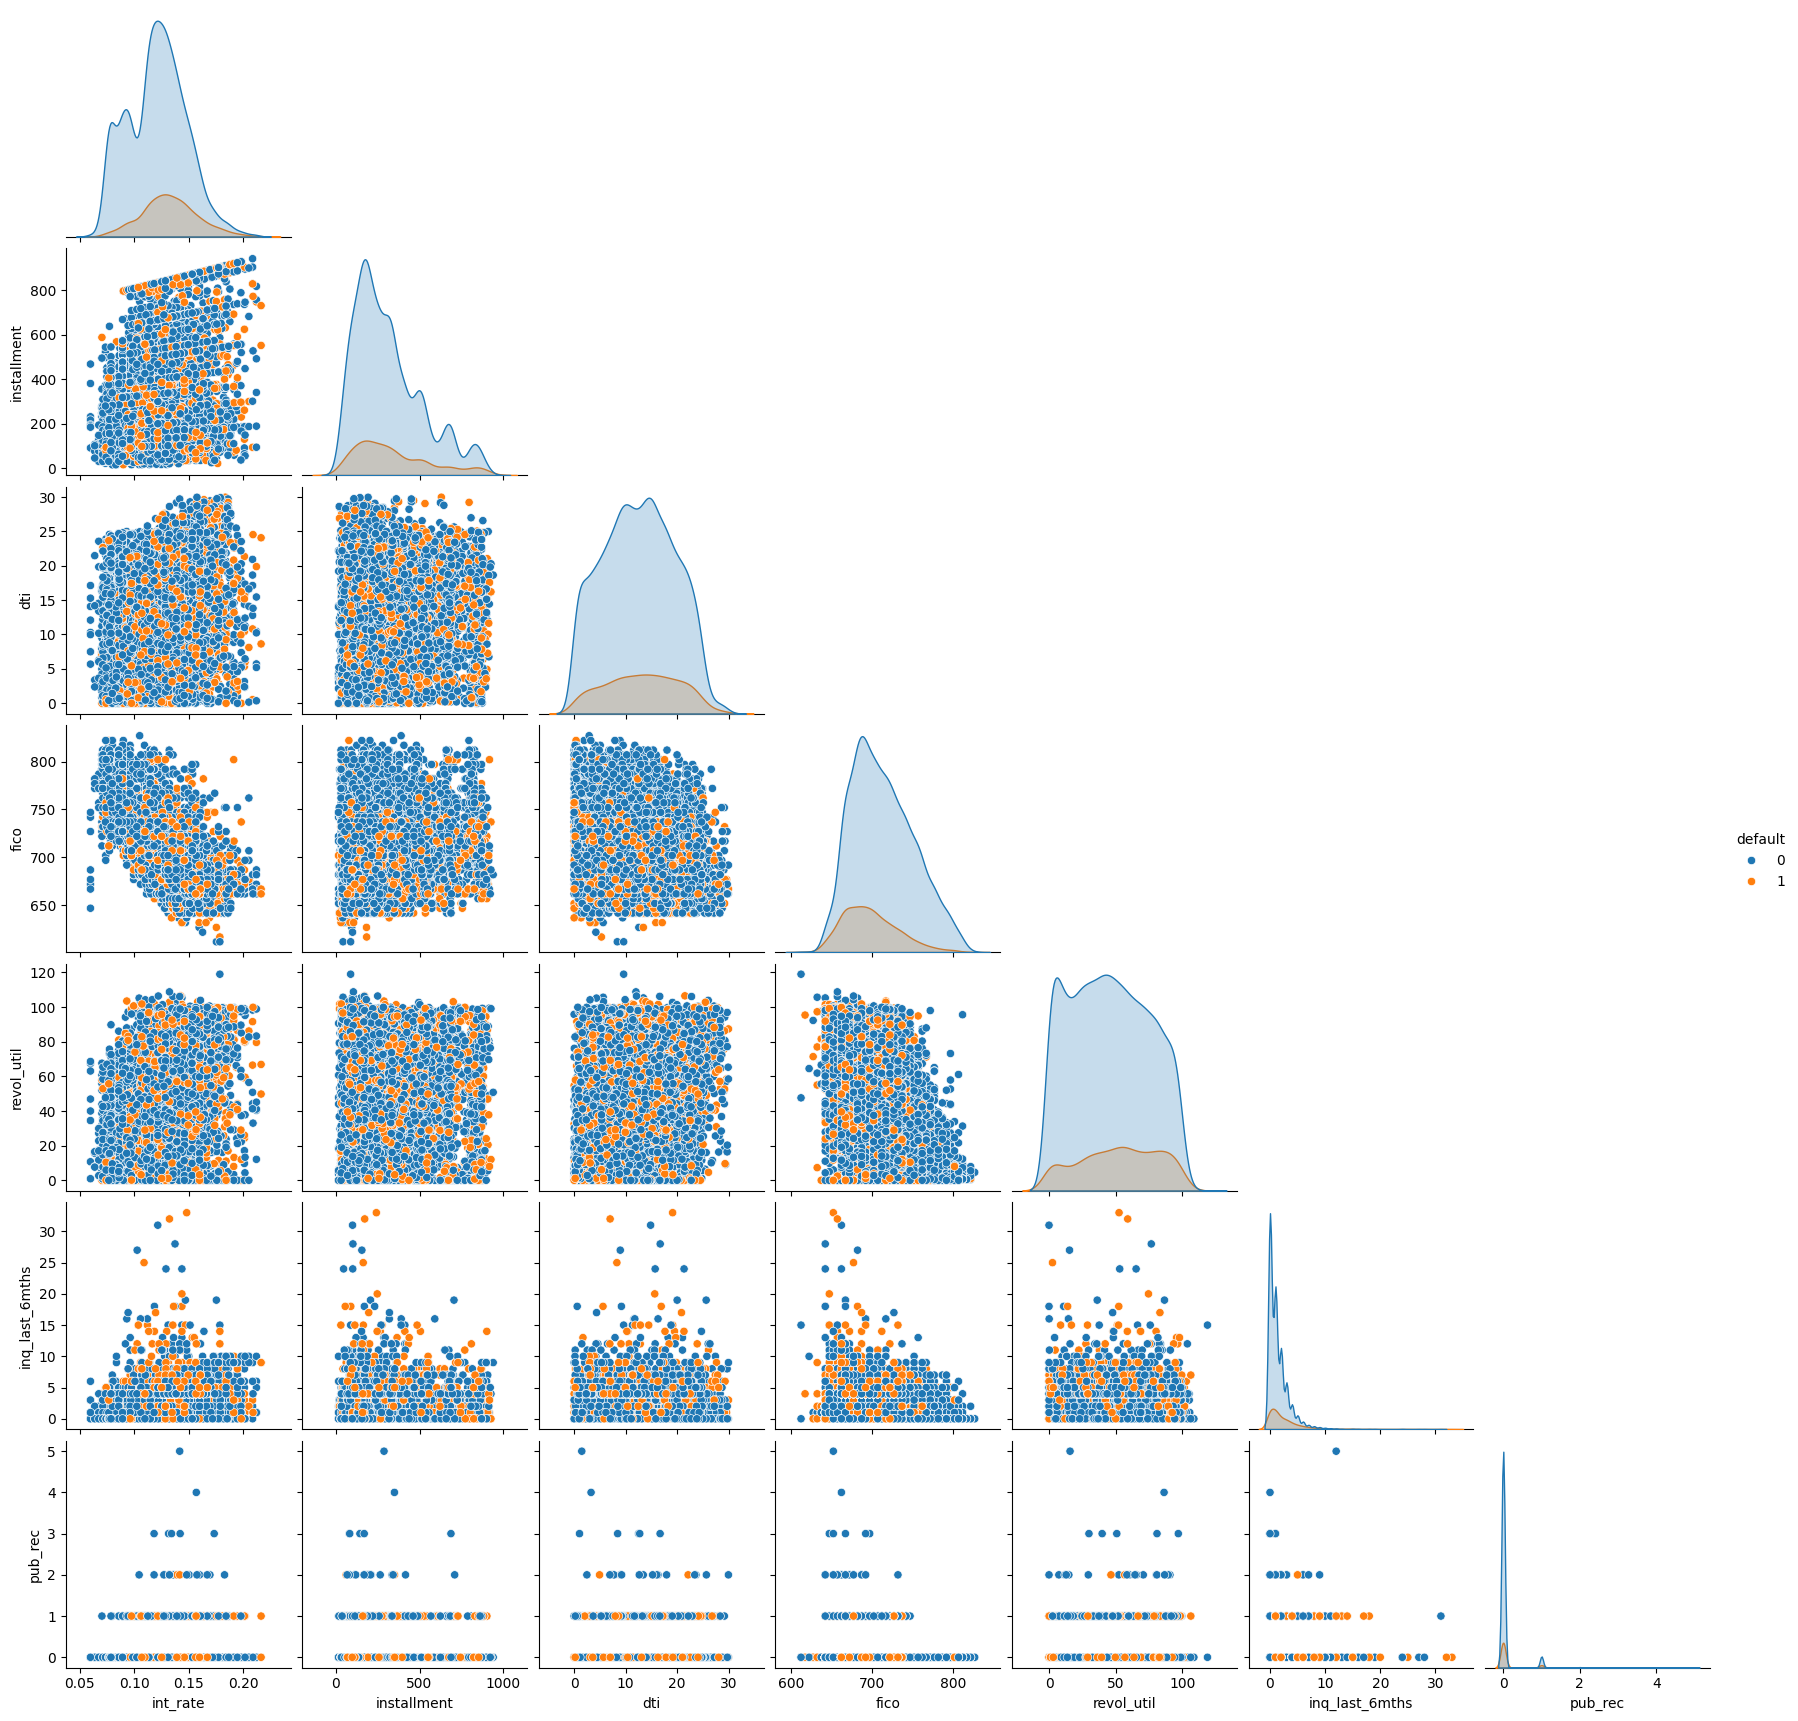

In [50]:
num_vars = df.drop(['purpose', 'log_annual_inc', 'days_with_cr_line', 'revol_bal', 'delinq_2yrs', 'credit_policy'], axis=1)
sns.pairplot(data=num_vars, hue='default', corner=True)
plt.show()

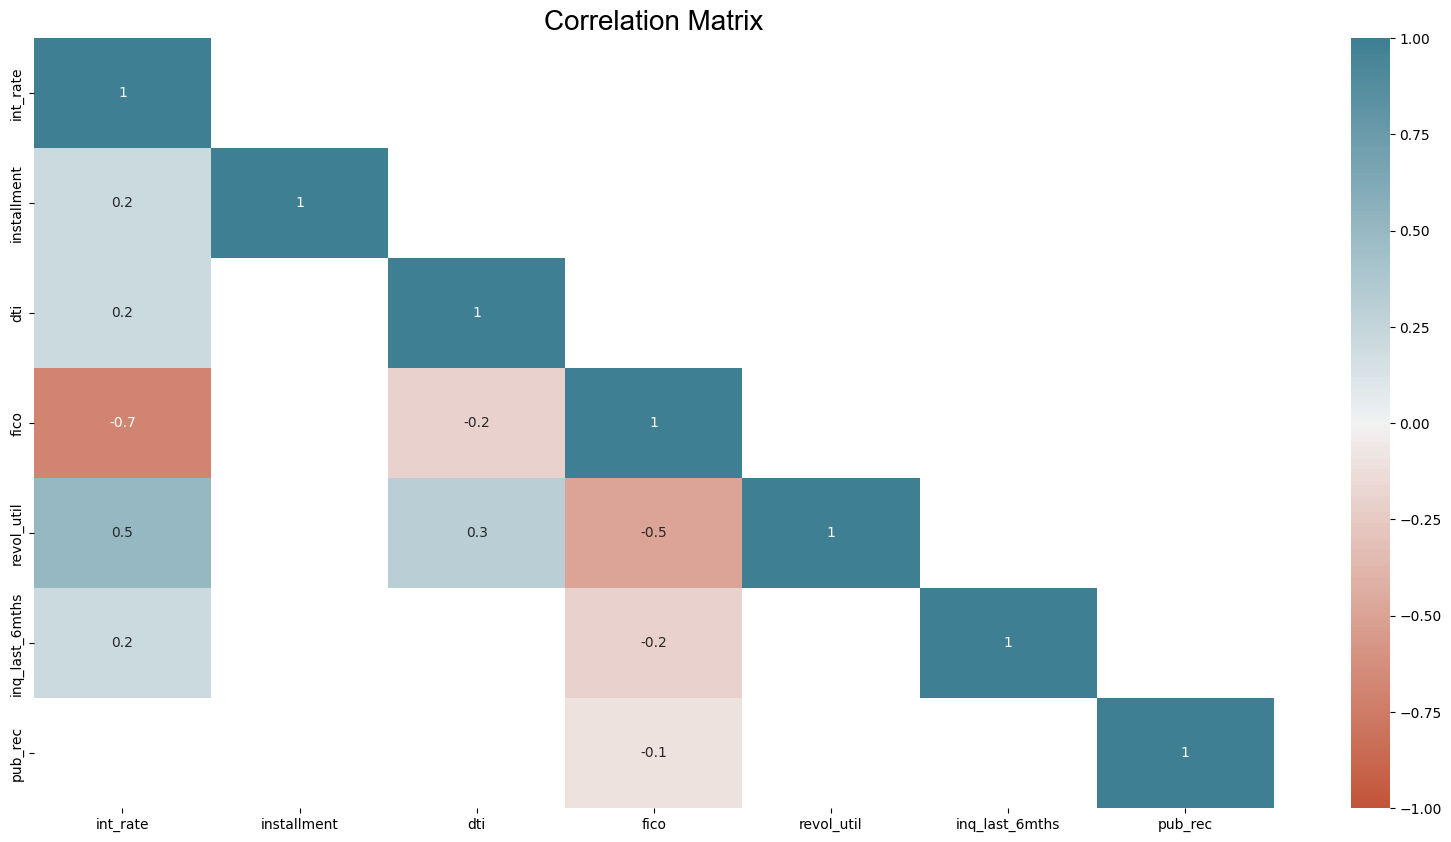

In [51]:
# Correlation Matrix
num_vars = df.drop(['default', 'purpose', 'log_annual_inc', 'days_with_cr_line', 'revol_bal', 'delinq_2yrs', 'credit_policy'], axis=1)
corr_mat = num_vars.corr(method='spearman')
# Select variable with a relationship over 10%
corr_mat = corr_mat[abs(corr_mat) >=  0.1]
corr_mat = corr_mat.round(1)

lower_mat = np.triu(corr_mat, k=1)

plt.figure(figsize=(20, 10))
sns.heatmap(corr_mat,
            annot=True, 
            vmin=-1, 
            vmax=1,
            cmap=sns.diverging_palette(20, 220, n=200),
            mask=lower_mat
           )
plt.title("Correlation Matrix", fontdict={'fontname': 'Arial', 'fontsize': 20})
plt.show()

- Fico score has a strong inverse relationship with the int_rate and revol_util variables
- The int_rate has a strong positive relationship with the revol_util variable

## Principal Component Analysis

In [52]:
def biplot(data, loadings, index1, index2, labels=None):
    """
    Function for plot principal components
    """
    plt.figure(figsize=(15, 7))
    xs = data[:,index1]
    ys = data[:,index2]
    n=loadings.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, loadings[i,index1], loadings[i,index2],color='r',alpha=0.5)
        if labels is None:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, labels[i], color='r', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(index1))
    plt.ylabel("PC{}".format(index2))
    plt.axvline(x=0, color='black', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.grid()

In [53]:
num_vars = df.select_dtypes(exclude=['object', 'category'])
num_vars = num_vars.drop('default', axis=1)

In [54]:
# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_vars.values)
scaled_data = pd.DataFrame(scaled_data,
                           columns=num_vars.columns,
                           index=num_vars.index
                           )

In [55]:
# Principal Components 
for comp in range(2, scaled_data.shape[1]):
    pca = PCA(n_components=comp, random_state=42)
    pca.fit(scaled_data)
    variance_acum = pca.explained_variance_ratio_
    final_comp = comp
    
    # Threshold for determine the number of principal components needed for a specified variance level
    threshold = 0.85
    if variance_acum.sum() >= threshold:
        print(f"Principal components that collect {threshold * 100}% of the variance: {final_comp}")
        break

Principal components that collect 85.0% of the variance: 8


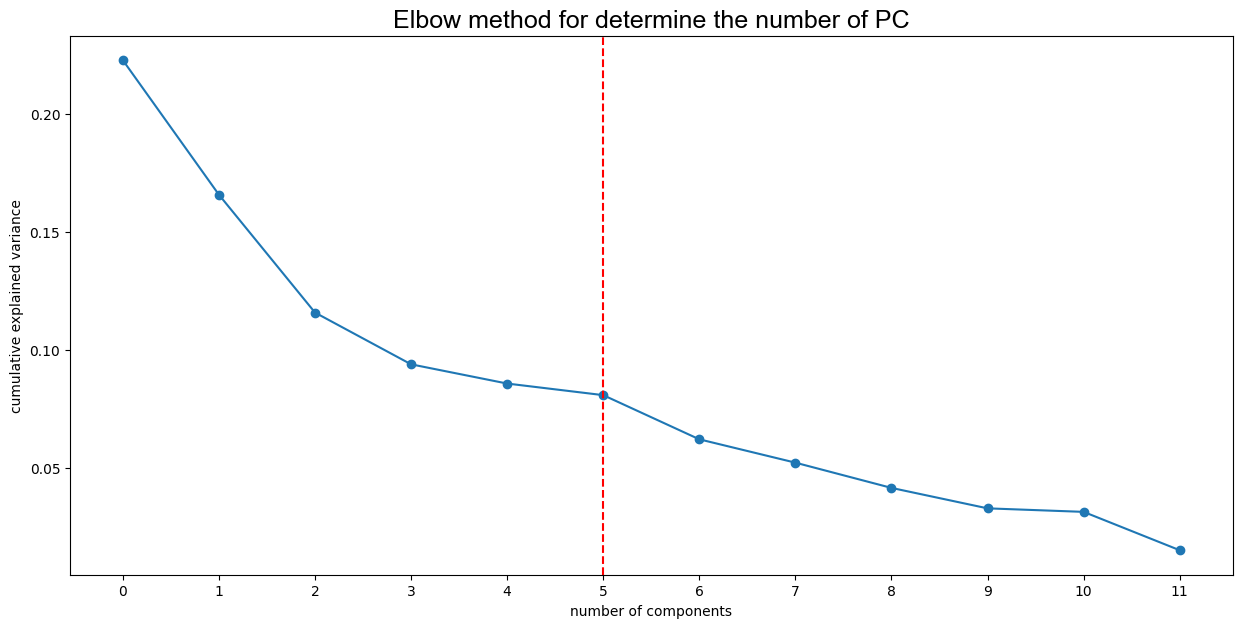

In [56]:
pca = PCA(random_state=42)
pca.fit(scaled_data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(var_exp, marker='o')
plt.title("Elbow method for determine the number of PC", fontdict={'fontname': 'Arial', 'fontsize':18})
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xticks(range(0, len(pca.components_)))
plt.axvline(x=5, linestyle='--', color='red')
plt.show()

In [57]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_vars.values)
scaled_data = pd.DataFrame(scaled_data,
                           columns=num_vars.columns,
                           index=num_vars.index)
pca = PCA(n_components=5, random_state=42)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

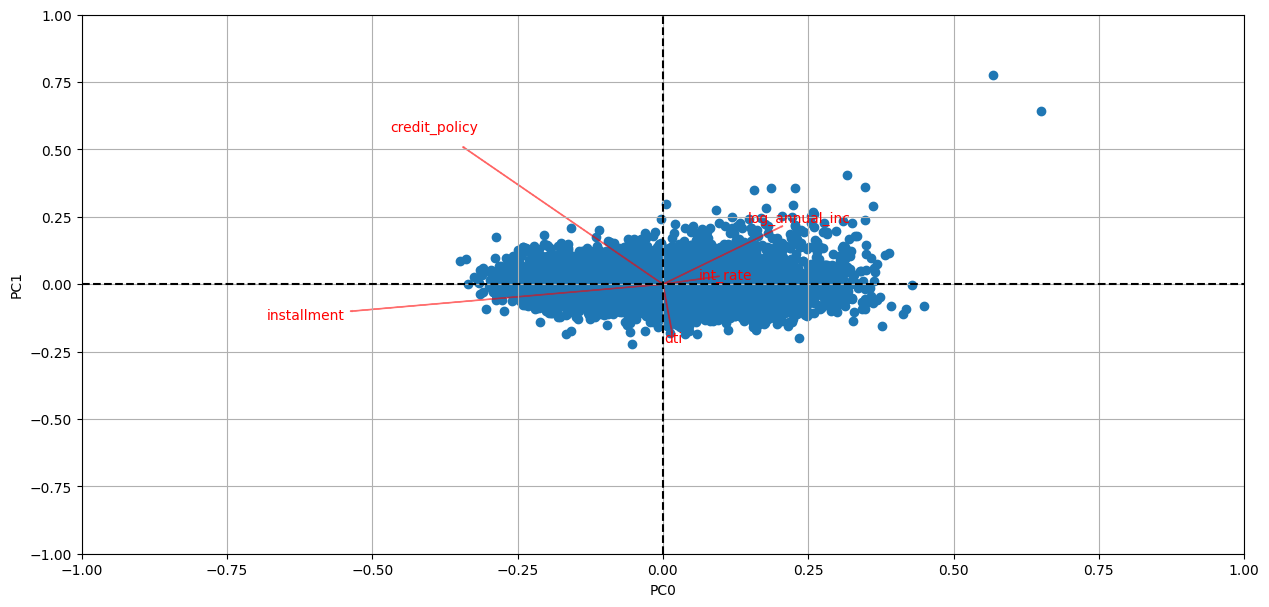

In [58]:
biplot(pca_data, pca.components_, 0, 1, scaled_data.columns.tolist())

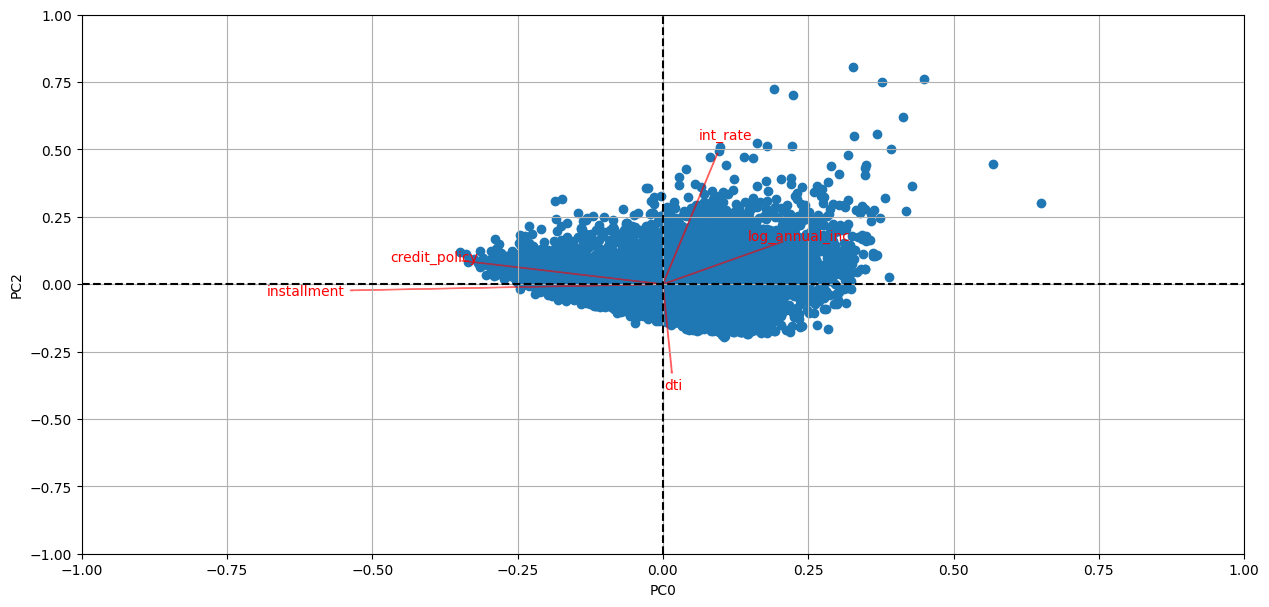

In [59]:
biplot(pca_data, pca.components_, 0, 2, scaled_data.columns.tolist())

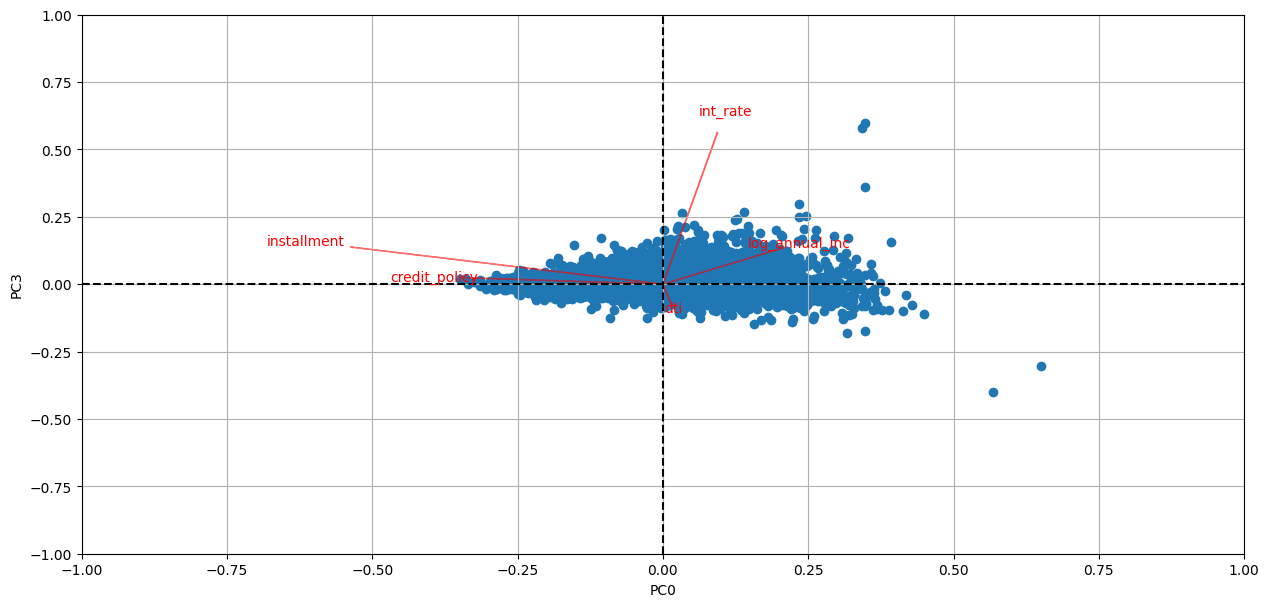

In [60]:
biplot(pca_data, pca.components_, 0, 3, scaled_data.columns.tolist())

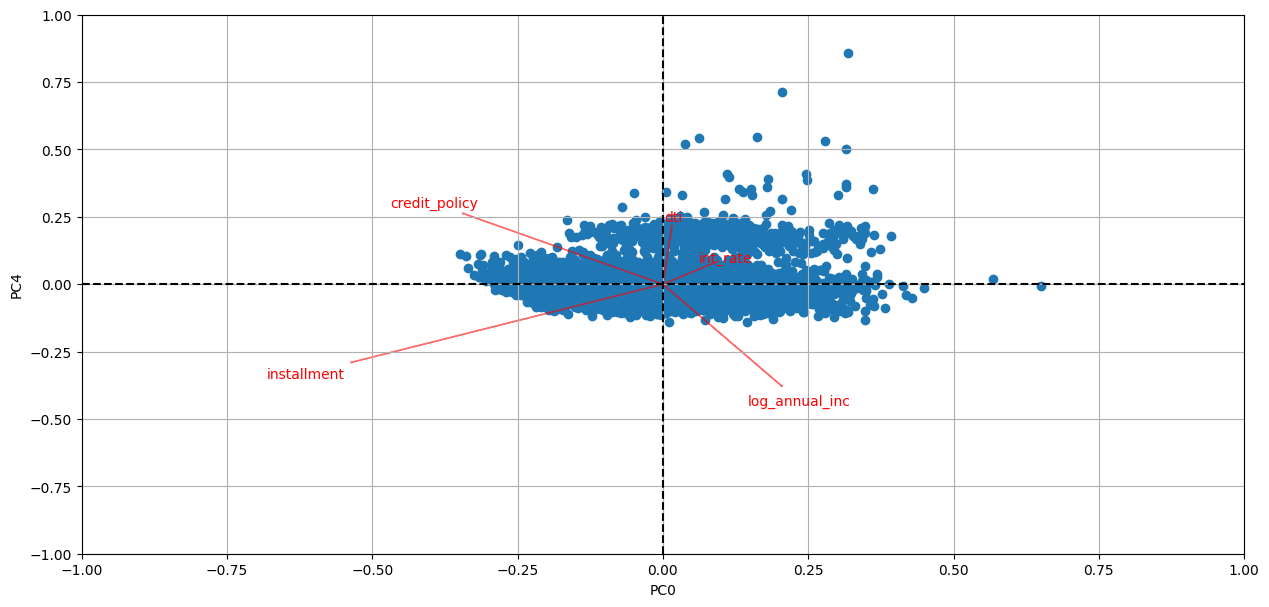

In [61]:
biplot(pca_data, pca.components_, 0, 4, scaled_data.columns.tolist())